In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [4]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [5]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [6]:
def show_tables():
    query= '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    ''' 
    return run_query(query)

In [7]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [8]:
query = '''
SELECT 
    g.name Genre, 
    SUM(il.quantity) Num_of_tracks_sold,
    CAST(SUM(il.quantity) AS FLOAT) * 100 / CAST((SELECT SUM(quantity) FROM invoice_line) AS FLOAT) AS "Num_of_tracks_sold%"
FROM track t 
LEFT JOIN genre g 
ON g.genre_id = t.genre_id
LEFT JOIN invoice_line il 
ON il.track_id = t.track_id
GROUP BY g.name
ORDER BY Num_of_tracks_sold DESC

'''
genre = run_query(query)
genre

,Genre,Num_of_tracks_sold,Num_of_tracks_sold%
0,Rock,2635.0,55.392054
1,Metal,619.0,13.012403
2,Alternative & Punk,492.0,10.342653
3,Latin,167.0,3.510616
4,R&B/Soul,159.0,3.342443
5,Blues,124.0,2.606685
6,Jazz,121.0,2.543620
7,Alternative,117.0,2.459533
8,Easy Listening,74.0,1.555602
9,Pop,63.0,1.324364


In [9]:
genre.set_index("Genre", inplace=True, drop=True)

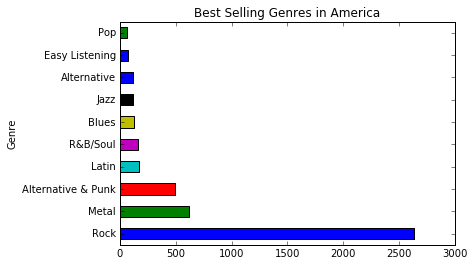

In [10]:

genre[0:10].plot.barh(title = "Best Selling Genres in America", y='Num_of_tracks_sold', legend=False)


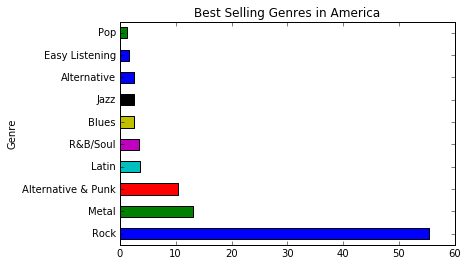

In [11]:
genre[0:10].plot.barh(title = "Best Selling Genres in America", y='Num_of_tracks_sold%', legend=False)

Based on the best selling genres in America, Rock is the dominant selling genre that comprises of 53% all track sales. Metal and Alternative & Punk were the next two most popular with approximately 10% of track sales each. The three artists should target three most popular genres as mentioned in order to gain larger track sales.

In [12]:
q = '''
SELECT 
    e.first_name || " " || e.last_name AS Sale_Support_Agent, 
    e.title AS Role,
    e.reports_to AS Report_To,
    e.city as City,
    COUNT(i.total) AS Num_of_Transactions,
    SUM(i.total) AS Total_Sales,
    CAST(SUM(i.total) AS FLOAT) *100 / (SELECT CAST(SUM(total) AS FLOAT) FROM invoice) AS "Total_Sales_%" 

From invoice i 
INNER JOIN customer c 
    ON c.customer_id = i.customer_id
INNER JOIN employee e
    ON e.employee_id = c.support_rep_id
GROUP BY Sale_Support_Agent
ORDER BY SUM(i.total) DESC
'''

Sales_Agent = run_query(q)
Sales_Agent

,Sale_Support_Agent,Role,Report_To,City,Num_of_Transactions,Total_Sales,Total_Sales_%
0,Jane Peacock,Sales Support Agent,2,Calgary,212,1731.51,36.766870
1,Margaret Park,Sales Support Agent,2,Calgary,214,1584.00,33.634644
2,Steve Johnson,Sales Support Agent,2,Calgary,188,1393.92,29.598486


In [13]:
Sales_Agent.set_index("Sale_Support_Agent", inplace=True, drop=True)

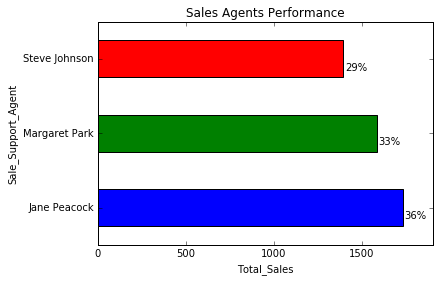

In [14]:

Sales_Agent.plot.barh(title = "Sales Agents Performance", y='Total_Sales',xlim=(0,1900),  legend=False)
plt.xlabel("Total_Sales")

for i, label in enumerate(list(Sales_Agent.index)):
    sales = Sales_Agent.loc[label, "Total_Sales"]
    label = (Sales_Agent.loc[label, "Total_Sales_%"] 
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (sales + 10, i - 0.15))

plt.show()


From the plot above, we can see that Jane Peacock leads the Sales Support Agent team with the most sales as Margaret Park and Steve Johnson are 3-7% behind Jane. Margaret and Jane both report to Steve as he is the team lead. His lower sales performance compared to the two could be due to his focus on other areas of the business such as training, management and meeting with other stakeholders in the business. 

In [15]:
c = '''


SELECT 
    c.country as Country,
    COUNT(distinct c.customer_id) as Total_Num_of_Customers,
    SUM(i.total) as Total_Value_of_Sales,
    CAST(SUM(i.total) as FLOAT) / CAST(COUNT(distinct c.customer_id) as FLOAT) as Avg_Value_of_Sales_per_Customer,
    CAST(SUM(i.total) as FLOAT) / CAST(COUNT(i.total) as FLOAT) as Avg_Order_Value

FROM customer c
LEFT JOIN invoice i
    ON i.customer_id = c.customer_id
GROUP BY c.country

'''
run_query(c)

,Country,Total_Num_of_Customers,Total_Value_of_Sales,Avg_Value_of_Sales_per_Customer,Avg_Order_Value
0,Argentina,1,39.60,39.600000,7.920000
1,Australia,1,81.18,81.180000,8.118000
2,Austria,1,69.30,69.300000,7.700000
3,Belgium,1,60.39,60.390000,8.627143
4,Brazil,5,427.68,85.536000,7.011148
5,Canada,8,535.59,66.948750,7.047237
6,Chile,1,97.02,97.020000,7.463077
7,Czech Republic,2,273.24,136.620000,9.108000
8,Denmark,1,37.62,37.620000,3.762000
9,Finland,1,79.20,79.200000,7.200000


In [16]:
c = '''


    

WITH country_cust as
    (

SELECT 
    c.country,
     
    CASE 
        WHEN COUNT(distinct c.customer_id)  = 1 THEN "Other"
        ELSE COUNT(distinct c.customer_id)
        END as Total_Customers
FROM customer c 
GROUP BY c.country
ORDER BY Total_Customers DESC 
    )



SELECT 
    country,
    Total_Customers
FROM
    ( 
    SELECT
        cc.*,
        CASE
            WHEN cc.Total_Customers = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM country_cust cc
    )
ORDER BY sort ASC

'''
run_query(c)

,country,Total_Customers
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,Other


In [17]:
c = '''

WITH country_cust as
    (

SELECT 
    *,
    COUNT(distinct c.customer_id) as distinct_num, 
    CASE 
        WHEN COUNT(distinct c.customer_id)  = 1 THEN "Other"
        ELSE COUNT(distinct c.customer_id)
        END as Total_Customers
FROM customer c 
GROUP BY c.country

    ),
    
distinct_cust as 
    (
    SELECT 
        COUNT(distinct c.customer_id) as tt
        FROM customer country_cust
        
    
    )


SELECT 
    c.country as Country,
    c.Total_Customers as Total_Num_of_Customers,
    SUM(i.total) as Total_Value_of_Sales,
    CAST(SUM(i.total) as FLOAT) / CAST( c.distinct_num as FLOAT) as Avg_Value_of_Sales_per_Customer,
    CAST(SUM(i.total) as FLOAT) / CAST(COUNT(i.total) as FLOAT) as Avg_Order_Value

FROM
    ( 
    SELECT
        cc.*,
        CASE
            WHEN cc.Total_Customers = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM country_cust cc
    ) as c

LEFT JOIN invoice i
    ON i.customer_id = c.customer_id
GROUP BY c.country
ORDER BY sort,  Total_Num_of_Customers DESC


'''
data = run_query(c)
data

,Country,Total_Num_of_Customers,Total_Value_of_Sales,Avg_Value_of_Sales_per_Customer,Avg_Order_Value
0,USA,13,72.27,5.559231,7.227000
1,Canada,8,75.24,9.405000,6.270000
2,Brazil,5,106.92,21.384000,7.128000
3,France,5,73.26,14.652000,6.105000
4,Germany,4,73.26,18.315000,8.140000
5,United Kingdom,3,79.20,26.400000,8.800000
6,Czech Republic,2,128.70,64.350000,10.725000
7,India,2,71.28,35.640000,8.910000
8,Portugal,2,82.17,41.085000,5.135625
9,Argentina,Other,39.60,39.600000,7.920000


In [18]:
c = '''

WITH country_cust as
    (

SELECT 
    *,
    COUNT(distinct c.customer_id) as distinct_num, 
    CASE 
        WHEN COUNT(distinct c.customer_id)  = 1 THEN "Other"
        ELSE COUNT(distinct c.customer_id)
        END as Total_Customers
FROM customer c 
GROUP BY c.country

    ),
    
distinct_cust as 
    (
    SELECT 
        COUNT(distinct c.customer_id) as tt
        FROM customer country_cust
        
    
    )


SELECT 
    c.country as Country,
    c.Total_Customers as Total_Num_of_Customers,
    SUM(i.total) as Total_Value_of_Sales,
    CAST(SUM(i.total) as FLOAT) / CAST( c.distinct_num as FLOAT) as Avg_Value_of_Sales_per_Customer,
    CAST(SUM(i.total) as FLOAT) / CAST(COUNT(i.total) as FLOAT) as Avg_Order_Value

FROM
    ( 
    SELECT
        cc.*,
        CASE
            WHEN cc.Total_Customers = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM country_cust cc
    ) as c

LEFT JOIN invoice i
    ON i.customer_id = c.customer_id
GROUP BY c.country
ORDER BY sort,  Total_Num_of_Customers DESC
LIMIT 9

'''
eight = run_query(c)
eight

,Country,Total_Num_of_Customers,Total_Value_of_Sales,Avg_Value_of_Sales_per_Customer,Avg_Order_Value
0,USA,13,72.27,5.559231,7.227000
1,Canada,8,75.24,9.405000,6.270000
2,Brazil,5,106.92,21.384000,7.128000
3,France,5,73.26,14.652000,6.105000
4,Germany,4,73.26,18.315000,8.140000
5,United Kingdom,3,79.20,26.400000,8.800000
6,Czech Republic,2,128.70,64.350000,10.725000
7,India,2,71.28,35.640000,8.910000
8,Portugal,2,82.17,41.085000,5.135625


In [19]:
data.set_index("Country", inplace=True, drop=True)

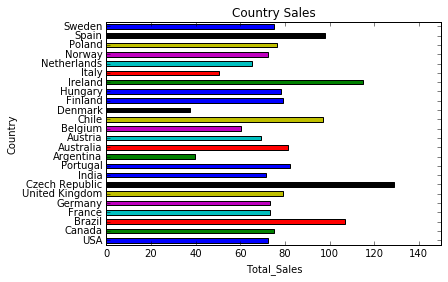

In [20]:
data.plot.barh(title = "Country Sales", y='Total_Value_of_Sales',xlim=(0,150),  legend=False)
plt.xlabel("Total_Sales")





plt.show()

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


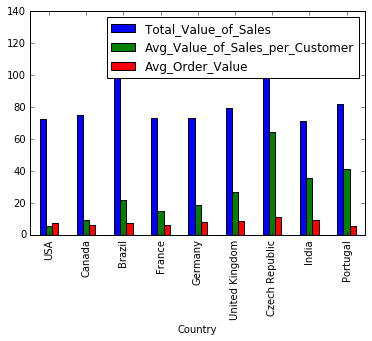

In [21]:
eight.set_index("Country", inplace=True, drop=True)
eight.plot.bar( y=['Total_Value_of_Sales', 'Avg_Value_of_Sales_per_Customer', 'Avg_Order_Value'])


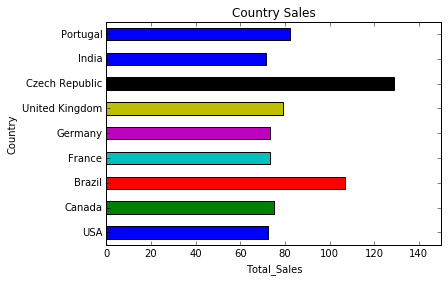

In [22]:
eight.plot.barh(title = "Country Sales", y='Total_Value_of_Sales',xlim=(0,150),  legend=False)
plt.xlabel("Total_Sales")

In [23]:
test= '''
SELECT
a.*,
t.name,
il.*,
COUNT(t.track_id) AS Numrecords
FROM invoice_line il
INNER JOIN track t
ON t.track_id = il.track_id
INNER JOIN album a 
ON a.album_id=t.album_id
GROUP BY il.invoice_id, invoice_line_id
'''
run_query(test)

,album_id,title,artist_id,name,invoice_line_id,invoice_id,track_id,unit_price,quantity,Numrecords
0,91,Use Your Illusion I,88,Right Next Door to Hell,1,1,1158,0.99,1,1
1,91,Use Your Illusion I,88,Dust N' Bones,2,1,1159,0.99,1,1
2,91,Use Your Illusion I,88,Live and Let Die,3,1,1160,0.99,1,1
3,91,Use Your Illusion I,88,Don't Cry (Original),4,1,1161,0.99,1,1
4,91,Use Your Illusion I,88,Perfect Crime,5,1,1162,0.99,1,1
5,91,Use Your Illusion I,88,You Ain't the First,6,1,1163,0.99,1,1
6,91,Use Your Illusion I,88,Bad Obsession,7,1,1164,0.99,1,1
7,91,Use Your Illusion I,88,Back off Bitch,8,1,1165,0.99,1,1
8,91,Use Your Illusion I,88,Double Talkin' Jive,9,1,1166,0.99,1,1
9,91,Use Your Illusion I,88,November Rain,10,1,1167,0.99,1,1


In [36]:
t = '''

SELECT
t.name,
a.*,
COUNT(t.track_id) AS Numrecords
FROM album a
INNER JOIN track t
ON t.album_id = a.album_id
GROUP BY t.album_id, t.track_id
'''
run_query(t)


,name,album_id,title,artist_id,Numrecords
0,For Those About To Rock (We Salute You),1,For Those About To Rock We Salute You,1,1
1,Put The Finger On You,1,For Those About To Rock We Salute You,1,1
2,Let's Get It Up,1,For Those About To Rock We Salute You,1,1
3,Inject The Venom,1,For Those About To Rock We Salute You,1,1
4,Snowballed,1,For Those About To Rock We Salute You,1,1
5,Evil Walks,1,For Those About To Rock We Salute You,1,1
6,C.O.D.,1,For Those About To Rock We Salute You,1,1
7,Breaking The Rules,1,For Those About To Rock We Salute You,1,1
8,Night Of The Long Knives,1,For Those About To Rock We Salute You,1,1
9,Spellbound,1,For Those About To Rock We Salute You,1,1


In [35]:
t = '''

SELECT
t.name
FROM invoice_line il
INNER JOIN track t
ON t.track_id = il.track_id
INNER JOIN album a 
ON a.album_id=t.album_id
WHERE il.invoice_id = 1
GROUP BY invoice_line_id
'''
run_query(t)


,name
0,Right Next Door to Hell
1,Dust N' Bones
2,Live and Let Die
3,Don't Cry (Original)
4,Perfect Crime
5,You Ain't the First
6,Bad Obsession
7,Back off Bitch
8,Double Talkin' Jive
9,November Rain


In [33]:
t = '''

SELECT
t.name
FROM album a
INNER JOIN track t
ON t.album_id = a.album_id
Where t.album_id = 91
GROUP BY t.track_id
'''
run_query(t)

,name
0,Right Next Door to Hell
1,Dust N' Bones
2,Live and Let Die
3,Don't Cry (Original)
4,Perfect Crime
5,You Ain't the First
6,Bad Obsession
7,Back off Bitch
8,Double Talkin' Jive
9,November Rain


In [132]:
t = '''

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )


    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
   


'''

run_query(t)


,invoice_id,first_track_id,album_purchase
0,1,1158,yes
1,2,201,no
2,3,2516,no
3,4,748,no
4,5,1986,yes
5,6,30,no
6,7,42,no
7,8,81,no
8,9,196,no
9,10,2663,no


SELECT
a.album_id,
t.album_id as id
FROM invoice_line il
INNER JOIN track t
ON t.track_id = il.track_id
INNER JOIN album a 
ON a.album_id=t.album_id
WHERE il.invoice_id = 1
GROUP BY invoice_line_id

In [131]:
a = '''
WITH ids AS
(
    SELECT 
        il.invoice_id as inv_id,
        MAX(il.track_id) as trk_id
    FROM invoice_line il 
    GROUP by inv_id
)

SELECT 
    album_purchase,
    COUNT(inv_id) as "Number of Invoices",
    CAST(COUNT(inv_id) as FLOAT) * 100 / CAST((SELECT COUNT(distinct invoice_id)
FROM invoice_line) as FLOAT) as "Percentage of Invoices"

FROM
(
SELECT 
    
    ids_check.*,
    CASE 
        WHEN 
            (SELECT
                 inv.track_id 
             FROM invoice_line inv
             WHERE inv.invoice_id = ids_check.inv_id
            
             EXCEPT 

             SELECT 
                 t.track_id
             FROM track t
             WHERE t.album_id = (SELECT 
                                    tr.album_id 
                                 FROM track tr
                                 WHERE tr.track_id = ids_check.trk_id
                                 )
            ) IS NULL
        AND
            (SELECT
                 t.track_id
             FROM track t
             WHERE t.album_id = (SELECT 
                                    tr.album_id 
                                 FROM track tr
                                 WHERE tr.track_id = ids_check.trk_id
                                 )
             
             EXCEPT
             
             SELECT
                inv.track_id 
             FROM invoice_line inv
             WHERE inv.invoice_id = ids_check.inv_id
           
            ) IS NULL
THEN 1
ELSE 0
END as Album_Purchase

FROM ids ids_check
) AS check_album
GROUP BY Album_Purchase
'''
run_query(a)

,Album_Purchase,Number of Invoices,Percentage of Invoices
0,0,500,81.433225
1,1,114,18.566775
